In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

/Users/han/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data loading

In [2]:
data = pd.read_csv("../databases/processed_data/cd230831.csv")

data.head()

,datetime,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
0,2023-08-31 00:00:30,15.596670,15.558330,15.542780,15.555560,0.02,0.088700,-1.480000,150.0,710.0,998.0,293.079000,293.751000,293.731000,0.0
1,2023-08-31 00:01:00,15.594503,15.558330,15.538204,15.546651,0.02,0.088713,-1.474754,150.0,710.0,998.0,293.079033,293.751017,293.730633,0.0
2,2023-08-31 00:01:30,15.592003,15.558330,15.532924,15.536371,0.02,0.088762,-1.455082,150.0,710.0,998.0,293.080033,293.751517,293.719633,0.0
3,2023-08-31 00:02:00,15.590465,15.553758,15.537758,15.549443,0.02,0.088800,-1.440000,150.0,710.0,998.0,293.080951,293.752148,293.709721,0.0
4,2023-08-31 00:02:30,15.589075,15.548483,15.544148,15.566108,0.02,0.088800,-1.440000,150.0,710.0,998.0,293.079475,293.756574,293.731361,0.0


In [3]:
# 计算原始均值
mean_temp6 = data["temperature_channel6"].mean()
nan_count = data["temperature_channel6"].isna().sum()
zero_count = (data["temperature_channel6"] == 0).sum()

print(f"temperature_channel6 均值: {mean_temp6}")
print(f"NaN 个数: {nan_count} / {len(data)}")
print(f"0.0 个数: {zero_count} / {len(data)}")


temperature_channel6 均值: 2.2882097124537943
NaN 个数: 482 / 69112
0.0 个数: 7660 / 69112


In [4]:
print(data.columns)

Index(['datetime', 'cooling_channel0', 'cooling_channel1', 'cooling_channel10',
       'cooling_channel11', 'maxigauge_channel1', 'maxigauge_channel2',
       'maxigauge_channel3', 'maxigauge_channel4', 'maxigauge_channel5',
       'maxigauge_channel6', 'temperature_channel1', 'temperature_channel2',
       'temperature_channel5', 'temperature_channel6'],
      dtype='object')


In [5]:
data.shape

(69112, 15)

### Data processing

In [6]:
data["datetime"] = pd.to_datetime(data["datetime"])
data.set_index("datetime", inplace=True)

features = [
    "cooling_channel0", "cooling_channel1", "cooling_channel10", "cooling_channel11",
    "maxigauge_channel1", "maxigauge_channel2", "maxigauge_channel3", "maxigauge_channel4",
    "maxigauge_channel5", "maxigauge_channel6",
    "temperature_channel1", "temperature_channel2", "temperature_channel5", "temperature_channel6"
]

In [7]:
df = data[features]

# 查看数据基本信息
print(df.info()) 
print(df.head())  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69112 entries, 2023-08-31 00:00:30 to 2023-09-23 23:56:00
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cooling_channel0      69112 non-null  float64
 1   cooling_channel1      69112 non-null  float64
 2   cooling_channel10     69112 non-null  float64
 3   cooling_channel11     69112 non-null  float64
 4   maxigauge_channel1    69109 non-null  float64
 5   maxigauge_channel2    69109 non-null  float64
 6   maxigauge_channel3    69109 non-null  float64
 7   maxigauge_channel4    69109 non-null  float64
 8   maxigauge_channel5    69109 non-null  float64
 9   maxigauge_channel6    69109 non-null  float64
 10  temperature_channel1  68639 non-null  float64
 11  temperature_channel2  68626 non-null  float64
 12  temperature_channel5  68611 non-null  float64
 13  temperature_channel6  68630 non-null  float64
dtypes: float64(14)
memory usage: 7.9 MB

#### Random sampling  * 3000

In [8]:
df_sample = data.iloc[:6000]
df_sample

,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
datetime,,,,,,,,,,,,,,
2023-08-31 00:00:30,15.596670,15.558330,15.542780,15.555560,0.02000,0.088700,-1.480000,150.0,710.0,998.000000,293.079000,293.751000,293.731000,0.0
2023-08-31 00:01:00,15.594503,15.558330,15.538204,15.546651,0.02000,0.088713,-1.474754,150.0,710.0,998.000000,293.079033,293.751017,293.730633,0.0
2023-08-31 00:01:30,15.592003,15.558330,15.532924,15.536371,0.02000,0.088762,-1.455082,150.0,710.0,998.000000,293.080033,293.751517,293.719633,0.0
2023-08-31 00:02:00,15.590465,15.553758,15.537758,15.549443,0.02000,0.088800,-1.440000,150.0,710.0,998.000000,293.080951,293.752148,293.709721,0.0
2023-08-31 00:02:30,15.589075,15.548483,15.544148,15.566108,0.02000,0.088800,-1.440000,150.0,710.0,998.000000,293.079475,293.756574,293.731361,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01 00:58:00,30.866935,18.939099,29.221479,19.150767,0.00002,0.000501,-2.674565,152.0,733.0,0.013327,75.027860,96.939898,173.602583,0.0
2023-09-01 00:58:30,30.869990,18.929192,29.208609,19.155489,0.00002,0.000501,-2.677826,152.0,733.0,0.013311,75.011660,96.860723,173.428833,0.0
2023-09-01 00:59:00,30.855631,18.922390,29.199843,19.138397,0.00002,0.000501,-2.689836,152.0,733.0,0.013300,74.995460,96.781548,173.255083,0.0


In [11]:
print(f"起始时间: {df_sample.index.min()}")
print(f"结束时间: {df_sample.index.max()}")
print(f"数据总时长: {df_sample.index.max() - df_sample.index.min()}")


起始时间: 2023-08-31 00:00:30
结束时间: 2023-09-01 01:00:00
数据总时长: 1 days 00:59:30


In [9]:
df_sample_cleaned = df_sample.dropna()


#### MinMaxScaler

In [10]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_sample_cleaned)

print(f"scaler 's shape: {df_scaled.shape}")

scaler 's shape: (2974, 14)


In [11]:
print(df_sample.index)
print(type(df_sample.index))


DatetimeIndex(['2023-08-31 00:00:30', '2023-08-31 00:01:00',
               '2023-08-31 00:01:30', '2023-08-31 00:02:00',
               '2023-08-31 00:02:30', '2023-08-31 00:03:00',
               '2023-08-31 00:03:30', '2023-08-31 00:04:00',
               '2023-08-31 00:04:30', '2023-08-31 00:05:00',
               ...
               '2023-09-01 00:55:30', '2023-09-01 00:56:00',
               '2023-09-01 00:56:30', '2023-09-01 00:57:00',
               '2023-09-01 00:57:30', '2023-09-01 00:58:00',
               '2023-09-01 00:58:30', '2023-09-01 00:59:00',
               '2023-09-01 00:59:30', '2023-09-01 01:00:00'],
              dtype='datetime64[ns]', name='datetime', length=3000, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


#### Creat Time windows

In [12]:
input_length = 48  # 过去 24 小时
output_length = 24  # 预测未来 24 小时

def create_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length):
        X.append(data[i : i + input_length])  # 取过去 24 小时作为输入
        y.append(data[i + input_length : i + input_length + output_length])  # 取接下来的 24 小时作为目标
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X, y = create_sequences(df_scaled, input_length, output_length)

print(f"训练数据形状: {X.shape}, 目标数据形状: {y.shape}")


训练数据形状: torch.Size([2926, 24, 14]), 目标数据形状: torch.Size([2926, 24, 14])


/var/folders/jy/vkj9691d74d1py1j62q_0kn80000gn/T/ipykernel_23489/2746125798.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [14]:
X

tensor([[[0.0034, 0.0124, 0.0046,  ..., 0.9997, 0.9975, 0.0000],
         [0.0032, 0.0124, 0.0043,  ..., 0.9997, 0.9975, 0.0000],
         [0.0031, 0.0124, 0.0039,  ..., 0.9997, 0.9974, 0.0000],
         ...,
         [0.0053, 0.0190, 0.0067,  ..., 0.9997, 0.9975, 0.0000],
         [0.0052, 0.0192, 0.0067,  ..., 0.9997, 0.9974, 0.0000],
         [0.0051, 0.0195, 0.0066,  ..., 0.9997, 0.9974, 0.0000]],

        [[0.0032, 0.0124, 0.0043,  ..., 0.9997, 0.9975, 0.0000],
         [0.0031, 0.0124, 0.0039,  ..., 0.9997, 0.9974, 0.0000],
         [0.0030, 0.0114, 0.0043,  ..., 0.9997, 0.9973, 0.0000],
         ...,
         [0.0052, 0.0192, 0.0067,  ..., 0.9997, 0.9974, 0.0000],
         [0.0051, 0.0195, 0.0066,  ..., 0.9997, 0.9974, 0.0000],
         [0.0051, 0.0198, 0.0065,  ..., 0.9997, 0.9975, 0.0000]],

        [[0.0031, 0.0124, 0.0039,  ..., 0.9997, 0.9974, 0.0000],
         [0.0030, 0.0114, 0.0043,  ..., 0.9997, 0.9973, 0.0000],
         [0.0029, 0.0102, 0.0047,  ..., 0.9997, 0.9975, 0.

### Transformer

#### MPS GPU

In [13]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"训练集大小: {len(train_dataset)}, 批量大小: {batch_size}, 总批次数: {len(train_loader)}")


训练集大小: 2926, 批量大小: 32, 总批次数: 92


In [14]:
print(f"是否有 NaN in X: {torch.isnan(X).any()}")
print(f"是否有 NaN in y: {torch.isnan(y).any()}")

是否有 NaN in X: False
是否有 NaN in y: False


In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用设备: {device}")

class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_inputs=14, num_outputs=14, seq_len=24,  # 支持更长的时间序列
                 d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, 
                 dim_feedforward=128, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(num_inputs, d_model)
        self.output_proj = nn.Linear(d_model, num_outputs)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                         num_encoder_layers=num_encoder_layers,
                                         num_decoder_layers=num_decoder_layers,
                                         dim_feedforward=dim_feedforward,
                                         dropout=dropout, batch_first=True)
        #  **修正这里**，支持最大 168 个时间步
        self.pos_enc = nn.Parameter(torch.zeros(1, seq_len, d_model))  
        self.pos_dec = nn.Parameter(torch.zeros(1, seq_len, d_model))

    def forward(self, src, tgt):
        batch_size, src_len, _ = src.shape
        _, tgt_len, _ = tgt.shape

        #  **这里不会再报错，因为 pos_enc 的长度 >= src_len**
        src_emb = self.input_proj(src) + self.pos_enc[:, :src_len, :]
        tgt_emb = self.input_proj(tgt) + self.pos_dec[:, :tgt_len, :]

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(src.device)
        transformer_out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask)
        output = self.output_proj(transformer_out)
        return output

#  **初始化模型，确保 `seq_len=168`**
model = TimeSeriesTransformer(
    num_inputs=14, num_outputs=14, seq_len=24, 
    d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, 
    dim_feedforward=128, dropout= 0.1  # 降低 Dropout 避免丢失信息
).to(device)

使用设备: mps


In [25]:
num_epochs = 30
model = TimeSeriesTransformer().to(device)               # 初始化模型并移动到设备
criterion = nn.MSELoss()                                 # 均方误差损失
optimizer = optim.Adam(model.parameters(), lr=1e-3)      # Adam优化器

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        # 将数据移动到设备
        batch_x = batch_x.to(device)   # shape: (batch_size, 24, 14)
        batch_y = batch_y.to(device)   # shape: (batch_size, 24, 14)

        # **准备目标序列输入**：使用真实的未来序列 batch_y 作为解码器输入（教师强制）。 
        # 如果需要严格的自回归，可在此处将 batch_y Shift 一位并在开头添加起始标志。
        tgt_input = batch_y  # 这里直接使用完整目标序列作为输入（已在 forward 内部应用mask防止泄漏未来）

        # 前向传播计算输出
        outputs = model(batch_x, tgt_input)              # outputs.shape: (batch_size, 24, 14)
        loss = criterion(outputs, batch_y)               # 计算 MSE 损失，输出和目标形状一致

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)      # 累加当前batch的损失

    avg_loss = total_loss / len(train_dataset)  # 计算 epoch 的平均损失
    print(f"Epoch {epoch+1}, Training MSE: {avg_loss:.4f}")


Epoch 1, Training MSE: 0.0352
Epoch 2, Training MSE: 0.0104
Epoch 3, Training MSE: 0.0062
Epoch 4, Training MSE: 0.0044
Epoch 5, Training MSE: 0.0033
Epoch 6, Training MSE: 0.0027
Epoch 7, Training MSE: 0.0022
Epoch 8, Training MSE: 0.0018
Epoch 9, Training MSE: 0.0016
Epoch 10, Training MSE: 0.0014
Epoch 11, Training MSE: 0.0013
Epoch 12, Training MSE: 0.0011
Epoch 13, Training MSE: 0.0010
Epoch 14, Training MSE: 0.0009
Epoch 15, Training MSE: 0.0008
Epoch 16, Training MSE: 0.0008
Epoch 17, Training MSE: 0.0007
Epoch 18, Training MSE: 0.0007
Epoch 19, Training MSE: 0.0006
Epoch 20, Training MSE: 0.0005
Epoch 21, Training MSE: 0.0005
Epoch 22, Training MSE: 0.0004
Epoch 23, Training MSE: 0.0004
Epoch 24, Training MSE: 0.0004
Epoch 25, Training MSE: 0.0004
Epoch 26, Training MSE: 0.0004
Epoch 27, Training MSE: 0.0003
Epoch 28, Training MSE: 0.0003
Epoch 29, Training MSE: 0.0003
Epoch 30, Training MSE: 0.0003


#### Cuda - 跑这里

In [ ]:

class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_inputs=14, num_outputs=14, seq_len=24,  # 支持更长的时间序列
                 d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, 
                 dim_feedforward=128, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(num_inputs, d_model)
        self.output_proj = nn.Linear(d_model, num_outputs)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                         num_encoder_layers=num_encoder_layers,
                                         num_decoder_layers=num_decoder_layers,
                                         dim_feedforward=dim_feedforward,
                                         dropout=dropout, batch_first=True)
        #  **修正这里**，支持最大 168 个时间步
        self.pos_enc = nn.Parameter(torch.zeros(1, seq_len, d_model))  
        self.pos_dec = nn.Parameter(torch.zeros(1, seq_len, d_model))

    def forward(self, src, tgt):
        batch_size, src_len, _ = src.shape
        _, tgt_len, _ = tgt.shape

        #  **这里不会再报错，因为 pos_enc 的长度 >= src_len**
        src_emb = self.input_proj(src) + self.pos_enc[:, :src_len, :]
        tgt_emb = self.input_proj(tgt) + self.pos_dec[:, :tgt_len, :]

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(src.device)
        transformer_out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask)
        output = self.output_proj(transformer_out)
        return output

In [ ]:
import torch
from torch.utils.data import DataLoader

# 选择 CUDA 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  #  应该输出 "cuda"

# 优化 batch_size
batch_size = 64  

# 数据加载
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# 构建 Transformer
model = TimeSeriesTransformer(
    num_inputs=14, num_outputs=14, seq_len=24, 
    d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, 
    dim_feedforward=128, dropout=0.1
).to(device)

# 启用 Torch 编译加速
model = torch.compile(model)  #  提高计算速度 20-30%

# 定义优化器和损失函数
num_epochs = 50
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 开始训练
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        # 使用自回归预测
        tgt_input = batch_y[:, :1, :].clone()
        for t in range(24 - 1):  
            output = model(batch_x, tgt_input)
            next_pred = output[:, -1:, :]
            tgt_input = torch.cat([tgt_input, next_pred], dim=1)

        loss = criterion(tgt_input, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)

    avg_loss = total_loss / len(train_dataset)
    print(f"Epoch {epoch+1}, Training MSE: {avg_loss:.4f}")


Using device: mps


: 

In [ ]:
df_test = data.iloc[6000:7000]
# df_test

print(f"起始时间: {df_test.index.min()}")
print(f"结束时间: {df_test.index.max()}")
print(f"数据总时长: {df_test.index.max() - df_test.index.min()}")

df_test_cleaned = df_test.dropna()

# 归一化测试集（使用训练集的 scaler）
df_test_scaled = scaler.transform(df_test_cleaned)

print(f"测试集数据形状: {df_test_scaled.shape}")
print(f"是否有 NaN in X: {torch.isnan(X).any()}")
print(f"是否有 NaN in y: {torch.isnan(y).any()}")

# 生成时间序列数据
X_test, y_test = create_sequences(df_test_scaled, input_length, output_length)

print(f"测试集 X_test 形状: {X_test.shape}")  # 应该是 (样本数, 24, 14)
print(f"测试集 y_test 形状: {y_test.shape}")  # 应该是 (样本数, 24, 14)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

# 确保测试数据在 GPU 上
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32).to(device), 
    torch.tensor(y_test, dtype=torch.float32).to(device)
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_loss = 0.0

# 计算 MSE Loss
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x, batch_y[:, :1, :])  # ✅ 只用第一个时间步
        loss = criterion(outputs, batch_y)
        test_loss += loss.item() * batch_x.size(0)

    avg_test_loss = test_loss / len(test_dataset)
    print(f"`df_test` 测试集 MSE: {avg_test_loss:.4f}")

# 预测未来 24 小时
model.eval()
with torch.no_grad():
    last_24_hours = torch.tensor(X_test[0], dtype=torch.float32).unsqueeze(0).to(device)  # 取测试集第一组数据
    tgt_input = last_24_hours[:, :1, :].clone()
    predicted = []

    for t in range(24):  
        output = model(last_24_hours, tgt_input)
        next_pred = output[:, -1:, :]
        predicted.append(next_pred.cpu().numpy())  
        tgt_input = torch.cat([tgt_input, next_pred], dim=1)  

    predicted = np.concatenate(predicted, axis=1)  # **拼接完整预测序列**

# 可视化结果
sensor_idx = 3  # 选择第 3 个传感器
plt.figure(figsize=(12, 6))

# 真实数据（24 小时）
plt.plot(range(24), y_test[0][:, sensor_idx], label="True", marker="o")

# 预测数据
plt.plot(range(24), predicted[0][:24, sensor_idx], label="Predict", marker="s")

plt.xlabel("time/h")
plt.ylabel("value")
plt.title(f"Sensor {sensor_idx} - True vs Predict (`df_test`)")
plt.legend()
plt.grid()
plt.show()


#### test loader

In [26]:
df_test = data.iloc[6000:7000]
df_test

,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
datetime,,,,,,,,,,,,,,
2023-09-02 02:00:30,29.817738,18.479830,28.291837,18.585520,0.000013,0.0144,-2.703115,152.0,733.0,0.009268,48.764672,11.043818,29.067836,42.296270
2023-09-02 02:01:00,29.813592,18.486756,28.288039,18.596464,0.000013,0.0144,-2.700650,152.0,733.0,0.009268,48.753705,11.028326,29.039852,42.204893
2023-09-02 02:01:30,29.809704,18.495783,28.284149,18.609937,0.000013,0.0144,-2.688455,152.0,733.0,0.009266,48.742467,11.013138,29.009676,42.117640
2023-09-02 02:02:00,29.805817,18.504811,28.280259,18.623409,0.000013,0.0144,-2.676260,152.0,733.0,0.009263,48.729467,10.999921,28.965242,42.057190
2023-09-02 02:02:30,29.801929,18.513838,28.276369,18.636882,0.000013,0.0144,-2.664065,152.0,733.0,0.009261,48.716467,10.986704,28.920809,41.996740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 10:18:00,29.048780,18.282040,27.684820,18.367775,0.000011,0.0180,-2.671707,152.0,733.0,0.009109,35.729535,3.479216,4.200058,4.031564
2023-09-02 10:18:30,29.068780,18.291622,27.694402,18.384443,0.000011,0.0180,-2.666829,152.0,733.0,0.009126,35.730985,3.480501,4.200018,4.029544
2023-09-02 10:19:00,29.067696,18.290664,27.708444,18.394193,0.000011,0.0180,-2.661951,152.0,733.0,0.009143,35.731174,3.480590,4.199940,4.028856


In [27]:
print(f"起始时间: {df_test.index.min()}")
print(f"结束时间: {df_test.index.max()}")
print(f"数据总时长: {df_test.index.max() - df_test.index.min()}")

df_test_cleaned = df_test.dropna()

# 归一化测试集（使用训练集的 scaler）
df_test_scaled = scaler.transform(df_test_cleaned)

print(f"测试集数据形状: {df_test_scaled.shape}")


起始时间: 2023-09-02 02:00:30
结束时间: 2023-09-02 10:20:00
数据总时长: 0 days 08:19:30
测试集数据形状: (984, 14)


In [28]:
print(f"是否有 NaN in X: {torch.isnan(X).any()}")
print(f"是否有 NaN in y: {torch.isnan(y).any()}")

是否有 NaN in X: False
是否有 NaN in y: False


In [29]:
# 生成时间序列数据
X_test, y_test = create_sequences(df_test_scaled, input_length, output_length)

print(f"测试集 X_test 形状: {X_test.shape}")  # 应该是 (样本数, 24, 14)
print(f"测试集 y_test 形状: {y_test.shape}")  # 应该是 (样本数, 24, 14)


测试集 X_test 形状: torch.Size([936, 24, 14])
测试集 y_test 形状: torch.Size([936, 24, 14])


In [30]:
batch_size = 32
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_loss = 0.0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x, batch_y)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item() * batch_x.size(0)

    avg_test_loss = test_loss / len(test_dataset)
    
    print(f"`df_test` 测试集 MSE: {avg_test_loss:.4f}")



/var/folders/jy/vkj9691d74d1py1j62q_0kn80000gn/T/ipykernel_23489/2373178930.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))


`df_test` 测试集 MSE: 19.2223


In [31]:
model.eval()
with torch.no_grad():
    last_24_hours = torch.tensor(X_test[0], dtype=torch.float32).unsqueeze(0).to(device)  # 取测试集第一组数据
    predicted = model(last_24_hours, last_24_hours)  # 预测未来 24 小时
    predicted = predicted.cpu().numpy()


/var/folders/jy/vkj9691d74d1py1j62q_0kn80000gn/T/ipykernel_23489/3599789944.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_hours = torch.tensor(X_test[0], dtype=torch.float32).unsqueeze(0).to(device)  # 取测试集第一组数据


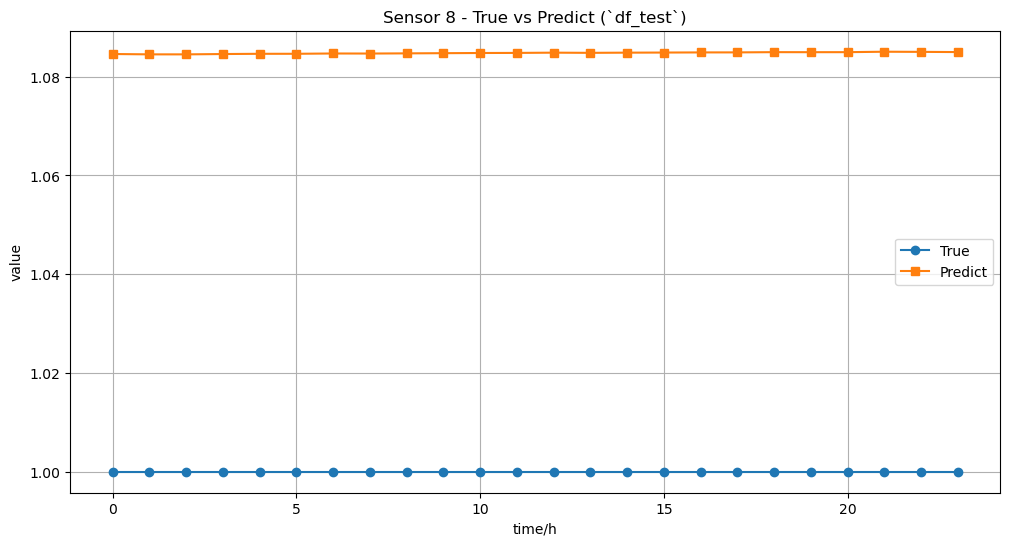

In [36]:
import matplotlib.pyplot as plt

sensor_idx = 8  # 选择第 1 个传感器

plt.figure(figsize=(12, 6))

# 真实数据（24 小时）
plt.plot(range(24), y_test[0][:, sensor_idx], label="True", marker="o")

# 预测数据（截取前 24 小时）
plt.plot(range(24), predicted[0][:24, sensor_idx], label="Predict", marker="s")

plt.xlabel("time/h")
plt.ylabel("value")
plt.title(f"Sensor {sensor_idx} - True vs Predict (`df_test`)")
plt.legend()
plt.grid()
plt.show()

